### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import absolute
np.random.seed(2018)

# Data wrangling & cleaning
import re
import string
from bs4 import BeautifulSoup
import lxml
import unicodedata
from datetime import datetime
import os 
import calendar
import dateutil.relativedelta
from collections import OrderedDict

# Topic modelling
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import nltk
from nltk.corpus import stopwords
import spacy
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")


# Prediction model

from scipy.stats import norm, skew
from scipy import stats

from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,make_scorer,confusion_matrix

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, train_test_split


from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline


import xgboost as xgb
from xgboost import XGBRegressor, plot_importance 



# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#Model extraction
import joblib
import pickle
import dill

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ozge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Datasets

In [3]:
#Upload json files
events=pd.read_json("data/events.json")
groups=pd.read_json("data/groups.json")
users=pd.read_json("data/users.json")
venues=pd.read_json("data/venues.json")

In [4]:
events

,description,group_id,created,rsvps,rsvp_limit,status,name,venue_id,time,duration
0,"<p><img src=""http://photos2.meetupstatic.com/p...",INTERNATIONALS-in-Rotterdam,1309088803000,"[{'guests': 0, 'when': 1309881442000, 'respons...",NaN,past,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,68572,1.310056e+12,NaN
1,<p>'s Avonds je laptop openklappen om iets leu...,codecave,1439890905000,"[{'guests': 0, 'when': 1439922626000, 'respons...",12.0,upcoming,Let's code some fun stuff!,67856,1.448476e+12,NaN
2,"<p>dear members,</p> <p>Friday 5th of November...",Digital-Museum-Network-Amsterdam,1287573554000,"[{'guests': 0, 'when': 1288771966000, 'respons...",12.0,past,Presentation of new applications/projects,67870,1.288962e+12,NaN
3,<p>Hi designers!</p> <p>\n\n\nIt's about time ...,ProductDesignMeetup,1413447279000,"[{'guests': 0, 'when': 1423688546000, 'respons...",100.0,past,Teamwork Wins Championships #Ghent,67397,1.423766e+12,10800000.0
4,"<p>Our first meet-up for GMG, called ""Beers &a...",The-Gamification-Meetup-Group,1338899209000,"[{'guests': 0, 'when': 1340573241000, 'respons...",NaN,past,Beers and Badges,68235,1.340726e+12,NaN
...,...,...,...,...,...,...,...,...,...,...
6195,<p>The first meetup of many. We will kick off ...,Amsterdam-Futurists-Society,1415798066000,"[{'guests': 0, 'when': 1417027043000, 'respons...",NaN,past,#1: Meet the Members.,68750,1.417028e+12,NaN
6196,<p>The Monthly Speaker Training meeting is an ...,Appsterdam,1350296891000,"[{'guests': 0, 'when': 1359379765000, 'respons...",7.0,past,Monthly Speaker Training Meeting,68803,1.359400e+12,NaN
6197,<p>Every Tuesday evening the ASCL teams are we...,Amsterdam-Smart-Citizens-Lab,1435146929000,"[{'guests': 0, 'when': 1436882736000, 'respons...",NaN,past,ASCL Open Tuesday Evening,67197,1.436890e+12,NaN
6198,"<p>Bitcoin Wednesday Amsterdam #25: <a href=""h...",BitcoinWednesday,1385307283000,"[{'guests': 0, 'when': 1435758596000, 'respons...",NaN,past,2nd Year Anniversary! Free Bitcoin Wednesday C...,67234,1.435763e+12,18000000.0


In [6]:
events.shape

(6200, 10)

In [8]:
# check percentage of NaN values in each column
events.isna().sum()/len(events)*100

description     2.306452
group_id        0.000000
created         0.000000
rsvps           0.000000
rsvp_limit     64.338710
status          0.000000
name            0.000000
venue_id        0.000000
time            0.274194
duration       58.064516
dtype: float64

In [9]:
events.loc[457]['created']

1348164642000

### Data Wrangling & Cleaning

In the case of prediction, sometimes the venue might not be assigned yet. However, we still want to predict the number of rsvp's. For that, we get a list of the most frequent venue for each group. If the venue is empty, we then assign the most frequent venue for the group.

In [10]:
#Aggregate based on group_id and venue_id and sort by the frequency. 
group_venue=events[['group_id','venue_id']].sort_values(by=['group_id'])
events_groups=events.groupby(["group_id", "venue_id"])["created"].count().sort_values(ascending=False).to_frame().reset_index()

#For each group_id, get the most frequent venue_id
events_groups_df=events_groups.groupby(["group_id"], as_index=False).first().set_index('group_id')
events_groups_df=events_groups_df[['venue_id']]

#Convert the results into dictionary and export.
f = open("Group_Value.pkl","wb")
pickle.dump(events_groups_df.to_dict(),f)
f.close()

In [11]:
#Obtain group_id from membership field and add it as a new column to users df
users['group_id']=users['memberships'].apply(lambda x: x[0]['group_id'])

#Obtain total user number for each group
user_count=users.groupby(['group_id'])['user_id'].count().to_frame().reset_index()

#Add total user number to the groups df
groups=groups.merge(user_count, on='group_id', how='left')

In [12]:
#Merge events and groups dataframes based on group_id
df_all=pd.merge(events, groups, on='group_id')

In [13]:
df_all.shape

(6200, 19)

In [14]:
df_all.rename(columns={"description_x": "Event_Description", "created_x": "Event_Created","name_x":"Event_Name","created_y":"Group_Created","description_y":"Group_Description","name_y":"Group_Name","user_id":"user_count","city":"group_city"}, inplace=True)

In [15]:
df_all.isna().sum()/len(df_all)*100

Event_Description     2.306452
group_id              0.000000
Event_Created         0.000000
rsvps                 0.000000
rsvp_limit           64.338710
status                0.000000
Event_Name            0.000000
venue_id              0.000000
time                  0.274194
duration             58.064516
topics                0.000000
group_city            0.000000
lon                   0.000000
Group_Created         0.000000
Group_Description     0.709677
link                  0.000000
Group_Name            0.000000
lat                   0.000000
user_count            0.032258
dtype: float64

In [16]:
#Add venues df based on venue_id
df_all=df_all.merge(venues, on='venue_id', how='left')
df_all.rename(columns={"city": "Event_City","country":"Event_Country"}, inplace=True)

In [17]:
df_all['status'].unique()

array(['past', 'cancelled', 'upcoming', 'suggested', 'proposed'],
      dtype=object)

### Missing Values

In [18]:
#Remove the records that do not have event time.
df_all = df_all.dropna(subset=['time'])

In [19]:
#If the user count is not filled, fill it with 0
df_all['user_count'] = df_all['user_count'].fillna(0)

In [20]:
df_all['duration'].mean()

24115153.846153848

In [21]:
#Impute duration with the mean.
df_all['duration']=df_all['duration'].fillna(df_all['duration'].mean())

In [22]:
#rsvp_limit has many nan values so convert them into a big number like 999.
df_all['rsvp_limit']=df_all['rsvp_limit'].fillna(999)

**Text Wrangling**

In [23]:
#Remove all the non string Event descriptions
df_all=df_all[df_all['Event_Description'].apply(lambda x: isinstance(x, str))==True]

In [24]:
#Original description
df_all['Event_Description'][0]

'<p><img src="http://photos2.meetupstatic.com/photos/event/1/0/3/e/event_11104158.jpeg" /> Dear\xa0<b>INTERNATIONALS</b>,</p> <p>\xa0</p> <p>As I write this, it is officially summer….too bad it doesn’t feel or look like it! But that won’t stop us, lets have a drink or two together on <b>July 7th!</b> We will keep our fingers crossed that we can enjoy some sun on the rooftop terrace of the Engels Grandcafe Rotterdam. Like always it will start at 18:30 and end around 23:30, looking forward to seeing the “regulars” and meeting some new people!</p> <p>\xa0</p> <p>We will welcome back DJ Rob. For those of you who don\'t him yet from our borrels, you may have heard him at the Bootleg dj-cafe or\xa0cafe De\xa0Witte Aap.</p> <p>\xa0</p> <p><b>\xa0</b></p> <p><b>WHAT</b>: Internationals meet Internationals- Midsummer afterwork drink - chat &amp; have fun!<br/><b>WHEN</b>:\xa0Thursday July 7th from\xa018:30-23:30.<br/><b>WHERE</b>: at Engels Grandcafe Restaurant Zalen -on the top floor of Engels

In [25]:
#Function to clean the description field. Clean description will be used as an input for the topic detection
def clean_description(decription_text):
    text_string = BeautifulSoup(decription_text, "lxml").text
    # remove numbers
    text_nonum = re.sub(r'\d+', '', unicodedata.normalize("NFKD",text_string))
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    #remove url
    text_no_url = re.sub('(http|https)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', text_nopunct, flags=re.MULTILINE)
    #remove bullet points
    text_no_bullet = re.sub('\d\.\s+|[a-z]\)\s+|•\s+|[A-Z]\.\s+|[IVX]+\.\s+',' ', text_no_url)
    #remove emails
    text_no_email = re.sub('\S*@\S*\s?', '', text_no_bullet) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_no_email).strip()
    
    return text_no_doublespace

In [26]:
#Clean the event description and event name texts
df_all['Event_Description']=df_all['Event_Description'].apply(lambda x: clean_description(x) )
df_all['Event_Name']=df_all['Event_Name'].apply(lambda x: clean_description(x) )

In [27]:
#Clean description
df_all['Event_Description'][0]

'dear internationals as i write this it is officially summertoo bad it doesn’t feel or look like it but that won’t stop us lets have a drink or two together on july th we will keep our fingers crossed that we can enjoy some sun on the rooftop terrace of the engels grandcafe rotterdam like always it will start at and end around looking forward to seeing the “regulars” and meeting some new people we will welcome back dj rob for those of you who dont him yet from our borrels you may have heard him at the bootleg djcafe or cafe de witte aap what internationals meet internationals midsummer afterwork drink chat have funwhen thursday july th from where at engels grandcafe restaurant zalen on the top floor of engels groothandelsgebouwhow to get there next to the rotterdam central train station stationplein entrance is from the stationplein side take the elevator up to the th floor of the building and follow the instructions which will take you to the top floor dress code none entrance fee non

**Time Wrangling**

In [28]:
#Get the day of the event from the epoch timestamp
df_all['Event_Day']=df_all['time'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime("%A"))

#Change the name of the days to number of the days. (Monday -->0,...)
days = dict(zip(calendar.day_name, range(7))); 
df_all['Event_Day']=df_all['Event_Day'].apply(lambda x: days[x])

#Get the hour of the event from the epoch timestamp
df_all['Event_Hour']=df_all['time'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime("%H"))

#Change epoch timestamps to datetime
df_all['time']=df_all['time'].apply(lambda x:datetime.strptime(datetime.fromtimestamp(x/1000).strftime('%m/%d/%y %H:%M:%S'), '%m/%d/%y %H:%M:%S'))
df_all['Event_Created']=df_all['Event_Created'].apply(lambda x:datetime.strptime(datetime.fromtimestamp(x/1000).strftime('%m/%d/%y %H:%M:%S'), '%m/%d/%y %H:%M:%S'))
df_all['Group_Created']=df_all['Group_Created'].apply(lambda x:datetime.strptime(datetime.fromtimestamp(x/1000).strftime('%m/%d/%y %H:%M:%S'), '%m/%d/%y %H:%M:%S'))

#Calculate Event Notice by calculating the difference between event time and event creation time
df_all['Event_Notice']=(df_all.time-df_all.Event_Created).astype('timedelta64[h]')

#Calculate Group Age by calculating the difference between event time and group creation time
df_all['Group_Age']=(df_all.time-df_all.Group_Created).astype('timedelta64[h]')

df_all['duration']=df_all['duration'].apply(lambda x:(x/(1000*60*60))%24)


In [29]:
#For some events Event time is before the event creation time. These cases are removed.
df_all=df_all[df_all['Event_Notice']>0]

In [30]:
#Export group_id-user_count mapping
f = open("Group_UserCount.pkl","wb")
pickle.dump(df_all[['group_id','user_count']].set_index('group_id').to_dict(),f)
f.close()

In [31]:
df_all.head()

,Event_Description,group_id,Event_Created,rsvps,rsvp_limit,status,Event_Name,venue_id,time,duration,...,user_count,Event_City,Event_Country,name,lon_y,lat_y,Event_Day,Event_Hour,Event_Notice,Group_Age
0,dear internationals as i write this it is offi...,INTERNATIONALS-in-Rotterdam,2011-06-26 13:46:43,"[{'guests': 0, 'when': 1309881442000, 'respons...",999.0,past,internationals meet internationals midsummer a...,68572,2011-07-07 18:30:00,6.698654,...,1995.0,Rotterdam,nl,Engels GrandCafé Restaurant Zalen,4.469535,51.923396,3,18,268.0,16654.0
1,dear internationals we would like to invite yo...,INTERNATIONALS-in-Rotterdam,2011-12-27 14:02:49,"[{'guests': 0, 'when': 1326227035000, 'respons...",999.0,past,internationals meet internationals in rotterda...,68572,2012-01-12 18:30:00,6.698654,...,1995.0,Rotterdam,nl,Engels GrandCafé Restaurant Zalen,4.469535,51.923396,3,18,388.0,21190.0
2,dear internationals we have the pleasure to in...,INTERNATIONALS-in-Rotterdam,2011-02-09 22:44:07,"[{'guests': 2, 'when': 1297832074000, 'respons...",999.0,past,internationals meet internationals the engels,68572,2011-02-18 18:30:00,6.698654,...,1995.0,Rotterdam,nl,Engels GrandCafé Restaurant Zalen,4.469535,51.923396,4,18,211.0,13318.0
3,dear internationals and dutchnatalie amanda ma...,INTERNATIONALS-in-Rotterdam,2013-04-02 19:40:35,"[{'guests': 0, 'when': 1365868955000, 'respons...",999.0,past,greg shapiro and pete johansson the th of apri...,68572,2013-04-14 20:00:00,6.698654,...,1995.0,Rotterdam,nl,Engels GrandCafé Restaurant Zalen,4.469535,51.923396,6,20,288.0,32184.0
4,dear internationals and dutch yes we want to k...,INTERNATIONALS-in-Rotterdam,2011-09-28 22:40:19,"[{'guests': 0, 'when': 1318446276000, 'respons...",999.0,past,internationals meet dutch,68572,2011-10-15 21:00:00,6.698654,...,1995.0,Rotterdam,nl,Engels GrandCafé Restaurant Zalen,4.469535,51.923396,5,21,406.0,19057.0


**Obtaining the target variable**

In [32]:
#Seperate past events from upcoming events
df=df_all[df_all['status']=='past']
df_test=df_all[df_all['status']=='upcoming']

In [33]:
#Get total rsvp-yes count from the rsvps column.
df['rsvp_count_yes'] =df['rsvps'].apply(lambda x: len([i for i in x if i['response'] == 'yes']))

In [34]:
df.describe()['rsvp_count_yes']

count    5464.000000
mean       20.427343
std        25.098828
min         0.000000
25%         5.000000
50%        12.000000
75%        27.000000
max       328.000000
Name: rsvp_count_yes, dtype: float64

In [35]:
df.shape

(5464, 29)

In [36]:
# check percentage of NaN values in each column
df.isna().sum()/len(df)*100

Event_Description    0.000000
group_id             0.000000
Event_Created        0.000000
rsvps                0.000000
rsvp_limit           0.000000
status               0.000000
Event_Name           0.000000
venue_id             0.000000
time                 0.000000
duration             0.000000
topics               0.000000
group_city           0.000000
lon_x                0.000000
Group_Created        0.000000
Group_Description    0.768668
link                 0.000000
Group_Name           0.000000
lat_x                0.000000
user_count           0.000000
Event_City           0.000000
Event_Country        0.000000
name                 0.000000
lon_y                0.000000
lat_y                0.000000
Event_Day            0.000000
Event_Hour           0.000000
Event_Notice         0.000000
Group_Age            0.000000
rsvp_count_yes       0.000000
dtype: float64

### Data Exploration

In [33]:
#For a certain period check how often events happen.
event_counts_df=df.resample('D', on='time').Event_Created.count().sort_index().to_frame().reset_index()
mask = (event_counts_df['time'] > '2012-01-01') & (event_counts_df['time'] <= '2012-03-01')
event_counts_df=event_counts_df.loc[mask]

In [313]:
fig = px.line(event_counts_df, x="time", y="Event_Created", title='Created Events')
fig.show()

In [314]:
#Get total number of rsvp yes based on day of the event
rpv_based_on_days = df.groupby(['Event_Day'])['rsvp_count_yes'].count().to_frame()
rpv_based_on_days = rpv_based_on_days.reindex(index = ['Monday','Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday']).reset_index()

<AxesSubplot:xlabel='Event_Day', ylabel='rsvp_count_yes'>

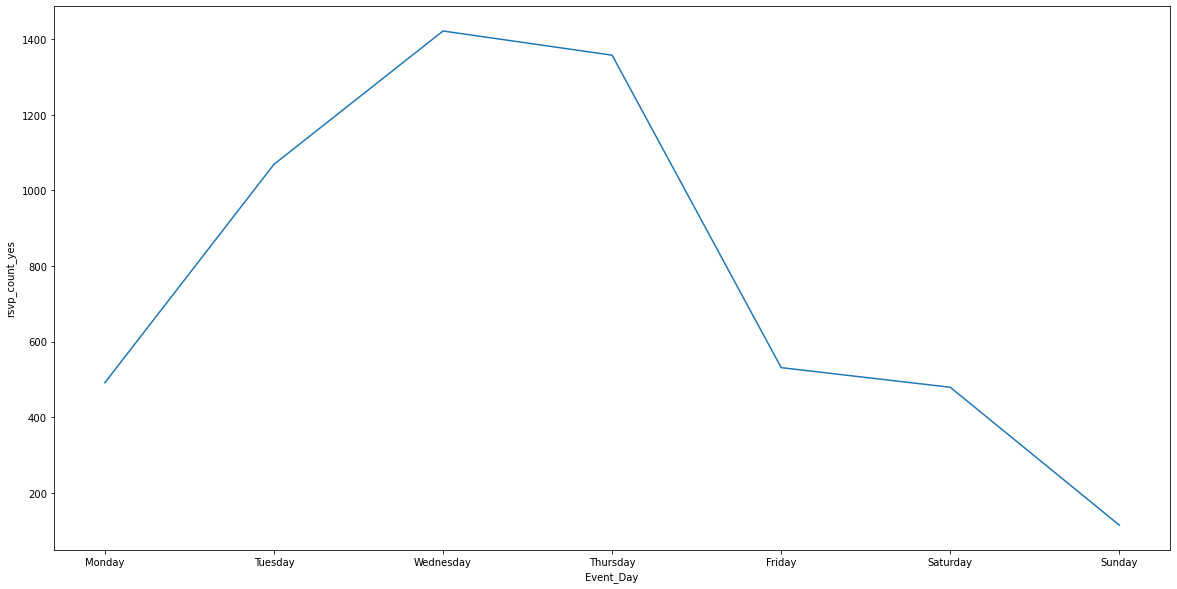

In [315]:
plt.figure(figsize=(20,10)) 
sns.lineplot(data=rpv_based_on_days, x='Event_Day', y='rsvp_count_yes')

Wednesdays and Thursdays are the days people rsvp more

In [316]:
#Get total number of rsvp yes based on time of the event
rpv_based_on_hours = df.groupby(['Event_Hour'])['rsvp_count_yes'].count().to_frame().sort_index().reset_index()

<AxesSubplot:xlabel='Event_Hour', ylabel='rsvp_count_yes'>

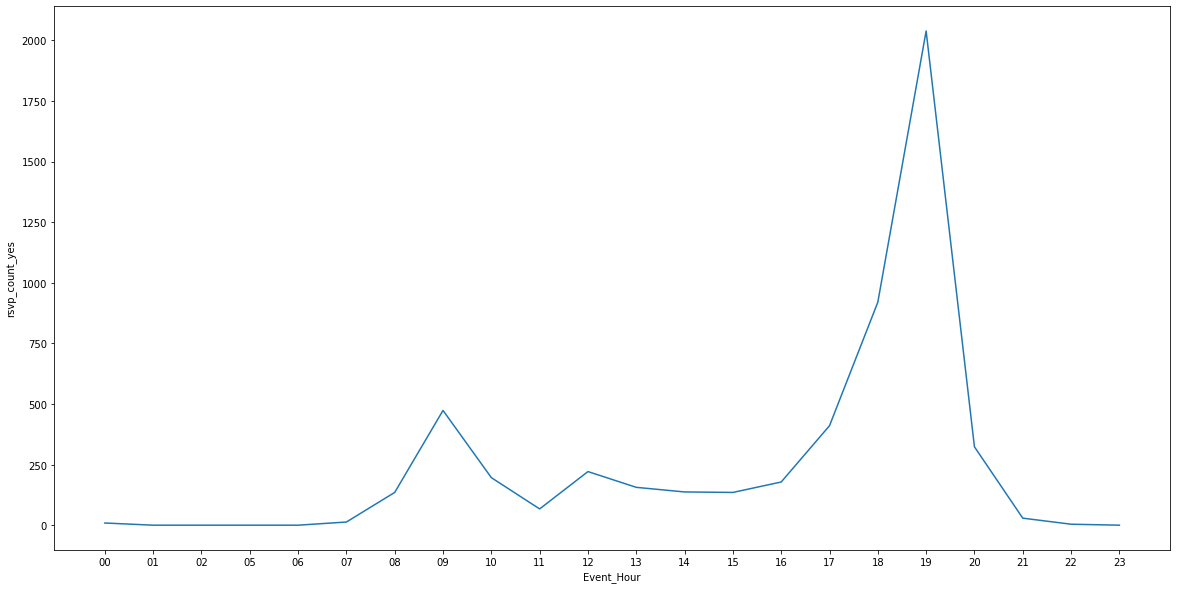

In [317]:
plt.figure(figsize=(20,10)) 
sns.lineplot(data=rpv_based_on_hours, x='Event_Hour', y='rsvp_count_yes')

For the events that starts at 19 people rsvp more

In [318]:
#Interactive chart
fig = px.line(rpv_based_on_hours, x="Event_Hour", y="rsvp_count_yes")
fig.show()

In [319]:
#Investigate the common effect of the day and time of the event
rpv_based_on_days_hours = df.groupby(['Event_Day','Event_Hour'])['rsvp_count_yes'].count().to_frame().reset_index()

In [320]:
fig = px.scatter(rpv_based_on_days_hours, x="Event_Hour", y="Event_Day",size='rsvp_count_yes', hover_data=['rsvp_count_yes'])
fig.show()

People seem to rsvp more on Wednesdays,Tuesdays and Thursday at 19:00

In [321]:
#Investigate the effect of total user count of the groups on rsvp yes count
rpv_based_on_group_size= df.groupby(['user_count'])['rsvp_count_yes'].sum().to_frame().sort_index().reset_index()

In [322]:
fig = px.line(rpv_based_on_group_size, x="user_count", y="rsvp_count_yes")
fig.show()

In [63]:

fig = px.scatter(df, x="duration", y="rsvp_count_yes", hover_data=['rsvp_count_yes'])
fig.show()

**Investigate Outliers**

Text(0.5, 1.0, 'rsvp_count_yes Distribution')

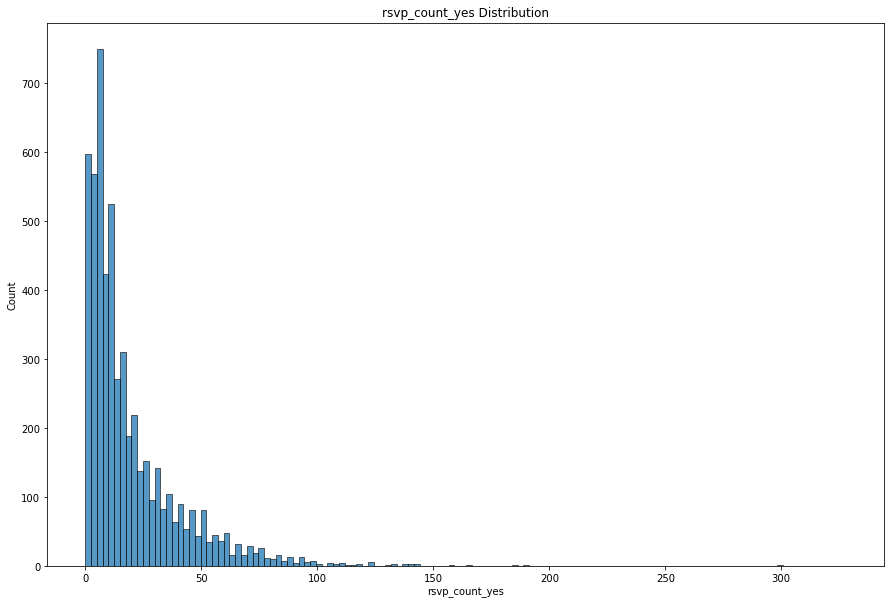

In [111]:
plt.figure(figsize=(15,10)) 
sns.histplot(df['rsvp_count_yes'], kde=False)
plt.title("rsvp_count_yes Distribution")

In [112]:
df['rsvp_count_yes'].max()

328

In [113]:
df[df['rsvp_count_yes']==328]

,Event_Description,group_id,Event_Created,rsvps,rsvp_limit,status,Event_Name,venue_id,time,duration,...,Event_City,Event_Country,name,lon_y,lat_y,Event_Day,Event_Hour,Event_Notice,Group_Age,rsvp_count_yes
2056,jaaa eindelijk is het dan zover het volledige ...,PermanentBeta,2014-07-02 11:42:14,"[{'guests': 0, 'when': 1415004934000, 'respons...",999.0,past,permanent beta dag,67911,2014-11-03 10:00:00,12.5,...,Amersfoort,nl,De Nieuwe Stad,5.381532,52.16095,0,10,2974.0,20829.0,328


The max case doesnt seem like an outlier.

In [37]:
#Remove the cases that have rsvp_count_yes as 0
df=df[df['rsvp_count_yes']>0]

In [38]:
df.shape

(5427, 29)

## Topic Modelling

In [39]:
#Get NLTK stopwords for English and Dutch
stopwords_dutch = stopwords.words('dutch')
stopwords_all = stopwords.words('english')

#Extend the stopword list with the common occurences of the topic
stopwords_all.extend(['join', 'meet', 'event', 'attend', 'time', 'day', 'week', 'group','pm', 'am',
                  'rsvp', 'come', 'register', 'contact','welcome','member', 'session',
                  'schedule', 'get', 'meetup','th','yet','also','de','let','lets','events','able','via'])

#Extend the list with Dutch stopwords
stopwords_all.extend(stopwords_dutch)

In [40]:
#Function to tokenize the given text
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in stopwords_all and len(token) > 3:
            result.append(token)
    return result

In [41]:
#Add tokenized words from event description as a new column
df['words_event_description'] = df['Event_Description'].map(preprocess)
df['words_event_name'] = df['Event_Name'].map(preprocess)

In [42]:
#Find the length of the words in event_description
df['Event_Description_Length']=df['words_event_description'].apply(lambda x: len(x))

In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['words_event_description'], min_count=5, threshold=100) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[df['words_event_description']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[df['words_event_description'][0]]])
print(trigram_mod[bigram_mod[df['words_event_name'][0]]])

['internationals_internationals', 'midsummer', 'afterwork_drink']


Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [44]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Function to lemmatize the given tokens
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
#Create bigrams based on tokenized event description
processed_docs_bigrams = make_bigrams(df['words_event_description'])
processed_docs_bigrams_event_name = make_bigrams(df['words_event_name'])

In [46]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [47]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(processed_docs_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_event_name = lemmatization(processed_docs_bigrams_event_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['dear_international', 'write', 'officially', 'summertoo', 'feel', 'look', 'stop', 'drink', 'together', 'cross', 'enjoy', 'always', 'start', 'meet', 'people', 'back', 'borrel', 'hear', 'next', 'train_station', 'floor', 'building', 'follow_instruction', 'take', 'code', 'none_entrance', 'noneimportant_organizer', 'entrance', 'find_mingle', 'guest', 'coming_purpose', 'work', 'people', 'good', 'together_encourage', 'good', 'opportunity_expand', 'picture_member', 'thanksbrbr', 'please']]


In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word_event_name = corpora.Dictionary(processed_docs_bigrams_event_name)

# Create Corpus
texts = data_lemmatized
texts_event_name = data_lemmatized_event_name


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
corpus_event_name = [id2word_event_name.doc2bow(text) for text in texts_event_name]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)]]


In [49]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('always', 1),
  ('back', 1),
  ('borrel', 1),
  ('building', 1),
  ('code', 1),
  ('coming_purpose', 1),
  ('cross', 1),
  ('dear_international', 1),
  ('drink', 1),
  ('enjoy', 1),
  ('entrance', 1),
  ('feel', 1),
  ('find_mingle', 1),
  ('floor', 1),
  ('follow_instruction', 1),
  ('good', 2),
  ('guest', 1),
  ('hear', 1),
  ('look', 1),
  ('meet', 1),
  ('next', 1),
  ('none_entrance', 1),
  ('noneimportant_organizer', 1),
  ('officially', 1),
  ('opportunity_expand', 1),
  ('people', 2),
  ('picture_member', 1),
  ('please', 1),
  ('start', 1),
  ('stop', 1),
  ('summertoo', 1),
  ('take', 1),
  ('thanksbrbr', 1),
  ('together', 1),
  ('together_encourage', 1),
  ('train_station', 1),
  ('work', 1),
  ('write', 1)]]

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.021*"drink" + 0.012*"location" + 0.011*"next" + 0.011*"food" + 0.010*"month" + 0.010*"people" + 0.009*"make" + 0.009*"last" + 0.009*"ticket" + 0.009*"night"'), (1, '0.014*"tijden" + 0.014*"presentatie" + 0.008*"sessie" + 0.008*"drone" + 0.008*"saman" + 0.008*"sind" + 0.007*"website" + 0.006*"plaat" + 0.006*"spreker" + 0.006*"deelnemer"'), (2, '0.013*"use" + 0.012*"datum" + 0.011*"talk" + 0.009*"application" + 0.008*"design" + 0.007*"technology" + 0.007*"software" + 0.007*"company" + 0.007*"user" + 0.007*"development"'), (3, '0.027*"open" + 0.022*"talk" + 0.015*"start" + 0.014*"work" + 0.013*"first" + 0.012*"startup" + 0.011*"project" + 0.011*"host" + 0.010*"code" + 0.010*"share"'), (4, '0.023*"monthly" + 0.017*"chance" + 0.016*"mind" + 0.011*"make_sure" + 0.010*"quite" + 0.010*"mask" + 0.007*"masked" + 0.007*"plattform" + 0.007*"hacker" + 0.006*"unsere"')]


In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.192960684990206

Coherence Score:  0.4912434083571872


In [229]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.187491  0.211729       1        1  41.737044
3      0.209335 -0.001361       2        1  31.307913
0      0.081197 -0.272568       3        1  17.706273
1     -0.282010  0.059173       4        1   6.497189
4     -0.196013  0.003027       5        1   2.751581, topic_info=            Term         Freq        Total Category  logprob  loglift
308         open  1830.000000  1830.000000  Default  30.0000  30.0000
28         start  1057.000000  1057.000000  Default  29.0000  29.0000
8          drink  1482.000000  1482.000000  Default  28.0000  28.0000
521         talk  2501.000000  2501.000000  Default  27.0000  27.0000
823          use  1177.000000  1177.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
14559      jetzt    19.466893    21.056583   Topic5  -5.7145   3.5145
113       masked    41.460299    74.561322   Topic5  -4.9584   3.0061
5116   wordpress    37.283289    67.727336   Topic5  -5.0646   2.9960
112         mask    60.820530   229.525298   Topic5  -4.5752   2.2649
2212     android    21.044146   132.994022   Topic5  -5.6365   1.7493

[267 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5018      4  0.996270  aantal
8069      5  0.941481   abend
4754      4  0.984016  alleen
0         1  0.008063  always
0         2  0.975605  always
...     ...       ...     ...
664       3  0.774576   would
68        1  0.564242    year
68        2  0.001493    year
68        3  0.434377    year
6006      4  0.995672    zoal

[343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

In [81]:
import joblib
# save the model to disk
filename_lda = 'lda_model_event_desc.sav'
joblib.dump(lda_model, filename_lda)

['lda_model_event_desc.sav']

Not a very good performance because the circles should not overlap in a good model

In [51]:
# Build LDA model
lda_model_event_name = gensim.models.ldamodel.LdaModel(corpus=corpus_event_name,
                                           id2word=id2word_event_name,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [184]:
# Print the Keyword in the 10 topics
print(lda_model_event_name.print_topics())
doc_lda_event_name = lda_model_event_name[corpus_event_name]

[(0, '0.048*"talk" + 0.034*"first" + 0.034*"drink" + 0.028*"design" + 0.024*"development" + 0.021*"learn" + 0.020*"coffee" + 0.015*"user" + 0.014*"developer" + 0.012*"code"'), (1, '0.020*"introduction" + 0.018*"summit" + 0.017*"build" + 0.016*"business" + 0.015*"online" + 0.015*"energy" + 0.014*"creative" + 0.012*"space" + 0.011*"part" + 0.010*"evening"'), (2, '0.081*"open" + 0.047*"meeting" + 0.031*"conference" + 0.030*"monthly" + 0.027*"seminar" + 0.015*"marketing" + 0.014*"live" + 0.012*"second" + 0.011*"software_craftsmanship" + 0.009*"hack"'), (3, '0.029*"startup" + 0.017*"dutch" + 0.016*"summer" + 0.015*"continuous_delivery" + 0.015*"organization" + 0.015*"night" + 0.014*"platform" + 0.014*"unconference" + 0.012*"exponential" + 0.012*"tech"')]


In [185]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_event_name.log_perplexity(corpus_event_name))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_event_name = CoherenceModel(model=lda_model_event_name, texts=data_lemmatized_event_name, dictionary=id2word_event_name, coherence='c_v')
coherence_model_lda_event_name = coherence_model_lda_event_name.get_coherence()
print('\nCoherence Score: ', coherence_model_lda_event_name)


Perplexity:  -7.90496235459139

Coherence Score:  0.740632251467952


In [230]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_event_name, corpus_event_name, id2word_event_name)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.203444 -0.023700       1        1  35.018110
2     -0.046439  0.132128       2        1  25.936642
1     -0.065603  0.040589       3        1  20.583828
3     -0.091402 -0.149016       4        1  18.461421, topic_info=           Term        Freq       Total Category  logprob  loglift
188        open  121.000000  121.000000  Default  30.0000  30.0000
417        talk   96.000000   96.000000  Default  29.0000  29.0000
219     meeting   71.000000   71.000000  Default  28.0000  28.0000
23        drink   68.000000   68.000000  Default  27.0000  27.0000
640       first   68.000000   68.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
184   hackathon    4.383380    4.834025   Topic4  -5.4902   1.5916
3386      stage    6.334812    7.209980   Topic4  -5.1219   1.5601
356       legal    5.990840    7.088694   Topic4  -5.1778   1.5212
3984   openbaar    8.002492   13.007788   Topic4  -4.8882   1.2037
771     journey    6.763527   13.468827   Topic4  -5.0564   1.0007

[170 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
457       1  1.000229     agile
1025      3  0.878506   ansible
3991      1  0.132015    apiled
3991      2  0.726085    apiled
3991      3  0.066008    apiled
...     ...       ...       ...
1130      1  0.984676   website
3787      3  0.973759      well
1759      2  0.890272    wetlab
309       4  0.990432  workshop
5         1  1.004303      year

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [82]:
import joblib
# save the model to disk
filename_lda2 = 'lda_model_event_name.sav'
joblib.dump(lda_model_event_name, filename_lda2)

['lda_model_event_name.sav']

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics , 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

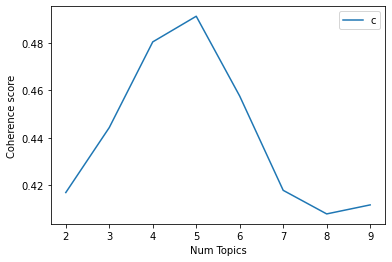

In [60]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4169
Num Topics = 3  has Coherence Value of 0.4443
Num Topics = 4  has Coherence Value of 0.4804
Num Topics = 5  has Coherence Value of 0.4912
Num Topics = 6  has Coherence Value of 0.4575
Num Topics = 7  has Coherence Value of 0.4178
Num Topics = 8  has Coherence Value of 0.4078
Num Topics = 9  has Coherence Value of 0.4116


In [62]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.021*"drink" + 0.012*"location" + 0.011*"next" + 0.011*"food" + 0.010*"month" + 0.010*"people" + 0.009*"make" + 0.009*"last" + 0.009*"ticket" + 0.009*"night"'),
 (1,
  '0.014*"tijden" + 0.014*"presentatie" + 0.008*"sessie" + 0.008*"drone" + 0.008*"saman" + 0.008*"sind" + 0.007*"website" + 0.006*"plaat" + 0.006*"spreker" + 0.006*"deelnemer"'),
 (2,
  '0.013*"use" + 0.012*"datum" + 0.011*"talk" + 0.009*"application" + 0.008*"design" + 0.007*"technology" + 0.007*"software" + 0.007*"company" + 0.007*"user" + 0.007*"development"'),
 (3,
  '0.027*"open" + 0.022*"talk" + 0.015*"start" + 0.014*"work" + 0.013*"first" + 0.012*"startup" + 0.011*"project" + 0.011*"host" + 0.010*"code" + 0.010*"share"'),
 (4,
  '0.023*"monthly" + 0.017*"chance" + 0.016*"mind" + 0.011*"make_sure" + 0.010*"quite" + 0.010*"mask" + 0.007*"masked" + 0.007*"plattform" + 0.007*"hacker" + 0.006*"unsere"')]

In [52]:
#function to find the topic number that has the highest percentage contribution in that document.
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)    
    return(sent_topics_df)


Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [53]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7806,"drink, location, next, food, month, people, ma...","[dear_international, write, officially, summer..."
1,1,0.0,0.7482,"drink, location, next, food, month, people, ma...","[dear_international, would_like, invite, year,..."
2,2,0.0,0.8722,"drink, location, next, food, month, people, ma...","[dear_international, pleasure, invite, next, a..."
3,3,0.0,0.5946,"drink, location, next, food, month, people, ma...","[pleasure, announce, international, comedynigh..."
4,4,0.0,0.7640,"drink, location, next, food, month, people, ma...","[autumn, season, really, sound, typical, warm,..."
5,5,0.0,0.9174,"drink, location, next, food, month, people, ma...","[dear_international, dutch, happy, spring, inv..."
6,6,0.0,0.8929,"drink, location, next, food, month, people, ma...","[dear_international, dutch, happy, spring, wou..."
7,7,0.0,0.7675,"drink, location, next, food, month, people, ma...","[international, textalign, leftbrwe, pleasure,..."
8,8,0.0,0.8741,"drink, location, next, food, month, people, ma...","[dear_international, next, take, place, starti..."
9,9,0.0,0.8294,"drink, location, next, food, month, people, ma...","[dear_international, year, international, cele..."


In [110]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==2.0]['Keywords']

68      use, datum, talk, application, design, technol...
69      use, datum, talk, application, design, technol...
70      use, datum, talk, application, design, technol...
72      use, datum, talk, application, design, technol...
73      use, datum, talk, application, design, technol...
                              ...                        
5406    use, datum, talk, application, design, technol...
5419    use, datum, talk, application, design, technol...
5420    use, datum, talk, application, design, technol...
5422    use, datum, talk, application, design, technol...
5423    use, datum, talk, application, design, technol...
Name: Keywords, Length: 1507, dtype: object

In [54]:
df_topic_sents_keywords_EN = format_topics_sentences(ldamodel=lda_model_event_name, corpus=corpus_event_name, texts=processed_docs_bigrams_event_name)

# Format
df_dominant_topic_EN = df_topic_sents_keywords_EN.reset_index()
df_dominant_topic_EN.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_EN.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_internationals, midsummer, aft..."
1,1,0.0,0.4220,"talk, first, drink, design, development, learn...","[internationals_internationals, rotterdam, spe..."
2,2,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_internationals, engels]"
3,3,0.0,0.3596,"talk, first, drink, design, development, learn...","[greg, shapiro, pete_johansson, april, engels,..."
4,4,0.0,0.3596,"talk, first, drink, design, development, learn...",[internationals_dutch]
5,5,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_dutch, spring, party, friday, ..."
6,6,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_dutch, spring, party]"
7,7,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_internationals, rotterdamth, m..."
8,8,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_internationals, engels]"
9,9,0.0,0.3596,"talk, first, drink, design, development, learn...","[internationals_internationals, engels, year_a..."


In [132]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9416,"drink, location, next, food, month, people, ma...","[great, year, party, back, informal, internati..."
1,1.0,0.9367,"tijden, presentatie, sessie, drone, saman, sin...","[gegeven, nicole, verandere, bovenstroom, onde..."
2,2.0,0.9517,"use, datum, talk, application, design, technol...","[spreaker, moderator, active, subnetwork, inte..."
3,3.0,0.9333,"open, talk, start, work, first, startup, proje...","[open, open, biodesigners_biohacker, open, eve..."
4,4.0,0.8992,"monthly, chance, mind, make_sure, quite, mask,...","[mehr, frage, ammaske, ammaske, nerd, einen, w..."


In [60]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"drink, location, next, food, month, people, ma...",777.0,0.1432
1.0,0.0,"drink, location, next, food, month, people, ma...",1074.0,0.1979
2.0,0.0,"drink, location, next, food, month, people, ma...",1507.0,0.2777
3.0,0.0,"drink, location, next, food, month, people, ma...",1759.0,0.3241
4.0,0.0,"drink, location, next, food, month, people, ma...",310.0,0.0571
...,...,...,...,...
5422.0,2.0,"use, datum, talk, application, design, technol...",NaN,NaN
5423.0,2.0,"use, datum, talk, application, design, technol...",NaN,NaN
5424.0,3.0,"open, talk, start, work, first, startup, proje...",NaN,NaN
5425.0,3.0,"open, talk, start, work, first, startup, proje...",NaN,NaN


In [78]:
df_dominant_topics[['Dominant_Topic','Topic_Keywords']].drop_duplicates().set_index('Topic_Keywords').to_dict()

,Dominant_Topic,Topic_Keywords
0.0,0.0,"drink, location, next, food, month, people, ma..."
59.0,1.0,"tijden, presentatie, sessie, drone, saman, sin..."
68.0,2.0,"use, datum, talk, application, design, technol..."
71.0,3.0,"open, talk, start, work, first, startup, proje..."
216.0,4.0,"monthly, chance, mind, make_sure, quite, mask,..."


In [57]:
#Add the topics to the df
df['Dominant_Topic'] = df_dominant_topic.Dominant_Topic.values
df['Dominant_Topic_Event_Name'] = df_dominant_topic_EN.Dominant_Topic.values
df['Topic_Perc_Contrib'] = df_dominant_topic.Topic_Perc_Contrib.values
df['Keywords_EventDescription'] = df_dominant_topic.Keywords.values

## Predicting Number of RSVP

### Split Training/Test

In [58]:
#Filter the dataset to only contain valuable fields. (Based on the domain)
filtered_df_API=df[['group_id','Event_Day','Event_Hour','Event_Notice','Dominant_Topic','rsvp_limit','rsvp_count_yes','Dominant_Topic_Event_Name','Event_Description_Length','duration','venue_id','user_count']]

In [59]:
#Apply some conversions to make the values integers.
filtered_df_API['user_count']=filtered_df_API['user_count'].apply(lambda x: int(x))
filtered_df_API['Event_Notice']=filtered_df_API['Event_Notice'].apply(lambda x: int(x))
#filtered_df_API['Group_Age']=filtered_df_API['Group_Age'].apply(lambda x: int(x))
filtered_df_API['rsvp_limit']=filtered_df_API['rsvp_limit'].apply(lambda x: int(x))
filtered_df_API['Event_Description_Length']=filtered_df_API['Event_Description_Length'].apply(lambda x: int(x))
filtered_df_API['duration']=filtered_df_API['duration'].apply(lambda x: int(x))

#Apply some conversions to make the categorical values strings.
filtered_df_API['Dominant_Topic']=filtered_df_API['Dominant_Topic'].apply(lambda x: str(x))
filtered_df_API['Dominant_Topic_Event_Name']=filtered_df_API['Dominant_Topic_Event_Name'].apply(lambda x: str(x))
filtered_df_API['Event_Day']=filtered_df_API['Event_Day'].apply(lambda x: str(x))
filtered_df_API['venue_id']=filtered_df_API['venue_id'].apply(lambda x: str(x))


**Target feature distribution**


 mu = 20.57 and sigma = 25.13



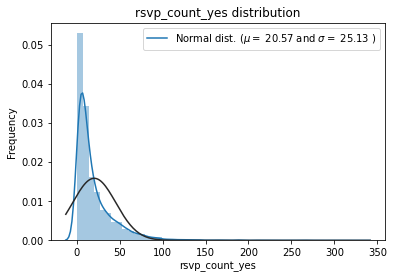

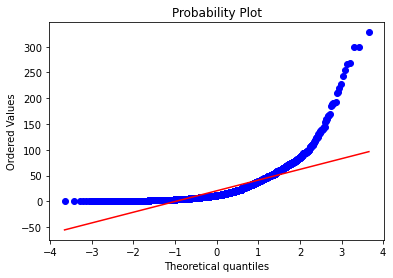

In [221]:
sns.distplot(filtered_df_API['rsvp_count_yes'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(filtered_df_API['rsvp_count_yes'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rsvp_count_yes distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(filtered_df_API['rsvp_count_yes'], plot=plt)
plt.show();

Target is right skewed

**Apply log-transformation**


 mu = 2.58 and sigma = 1.00



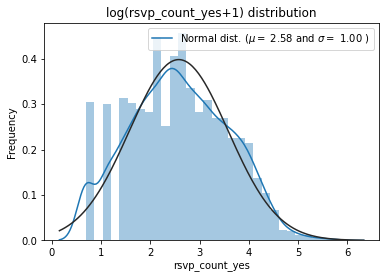

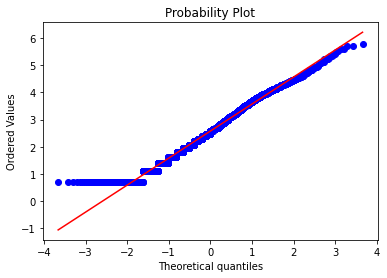

In [222]:
sns.distplot(np.log1p(filtered_df_API['rsvp_count_yes']) , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(filtered_df_API['rsvp_count_yes']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(rsvp_count_yes+1) distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(filtered_df_API['rsvp_count_yes']), plot=plt)
plt.show();

**Correlation between numeric features**

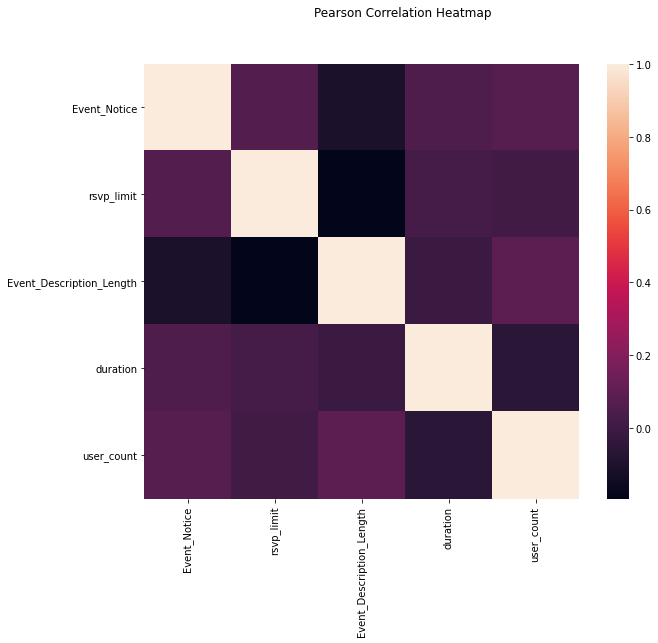

In [223]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df_API.drop(['rsvp_count_yes'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

No correlation

In [224]:
filtered_df_API.drop(['rsvp_count_yes'],axis=1).corr()

,Event_Notice,rsvp_limit,Event_Description_Length,duration,user_count
Event_Notice,1.00,0.06,-1.07e-01,5.27e-02,0.07
rsvp_limit,0.06,1.00,-1.95e-01,2.19e-02,0.01
Event_Description_Length,-0.11,-0.19,1.00e+00,-7.95e-03,0.09
duration,0.05,0.02,-7.95e-03,1.00e+00,-0.06
user_count,0.07,0.01,9.38e-02,-6.01e-02,1.00


**Correlation between rsvp_count_yes and the other numeric features**

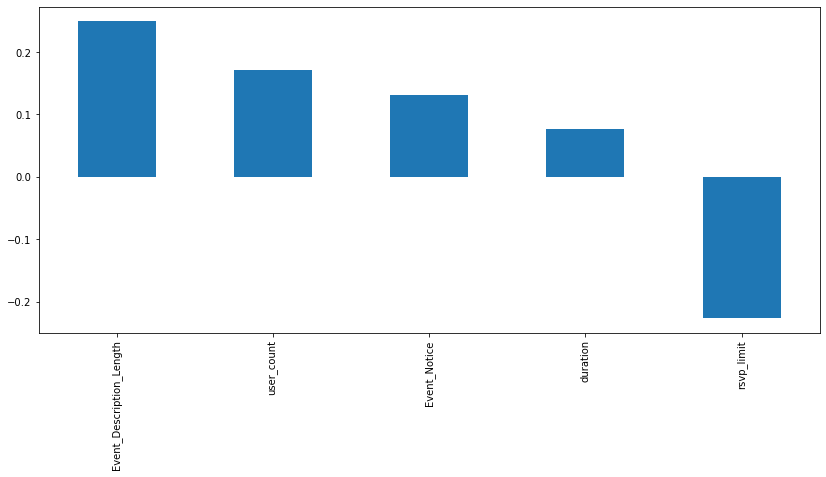

In [225]:
corr_with_sale_price = filtered_df_API.corr()["rsvp_count_yes"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("rsvp_count_yes").plot.bar()
plt.show();

The correlation of rsvp_count_yes with rsvp_limit is the greatest (around -0.20).

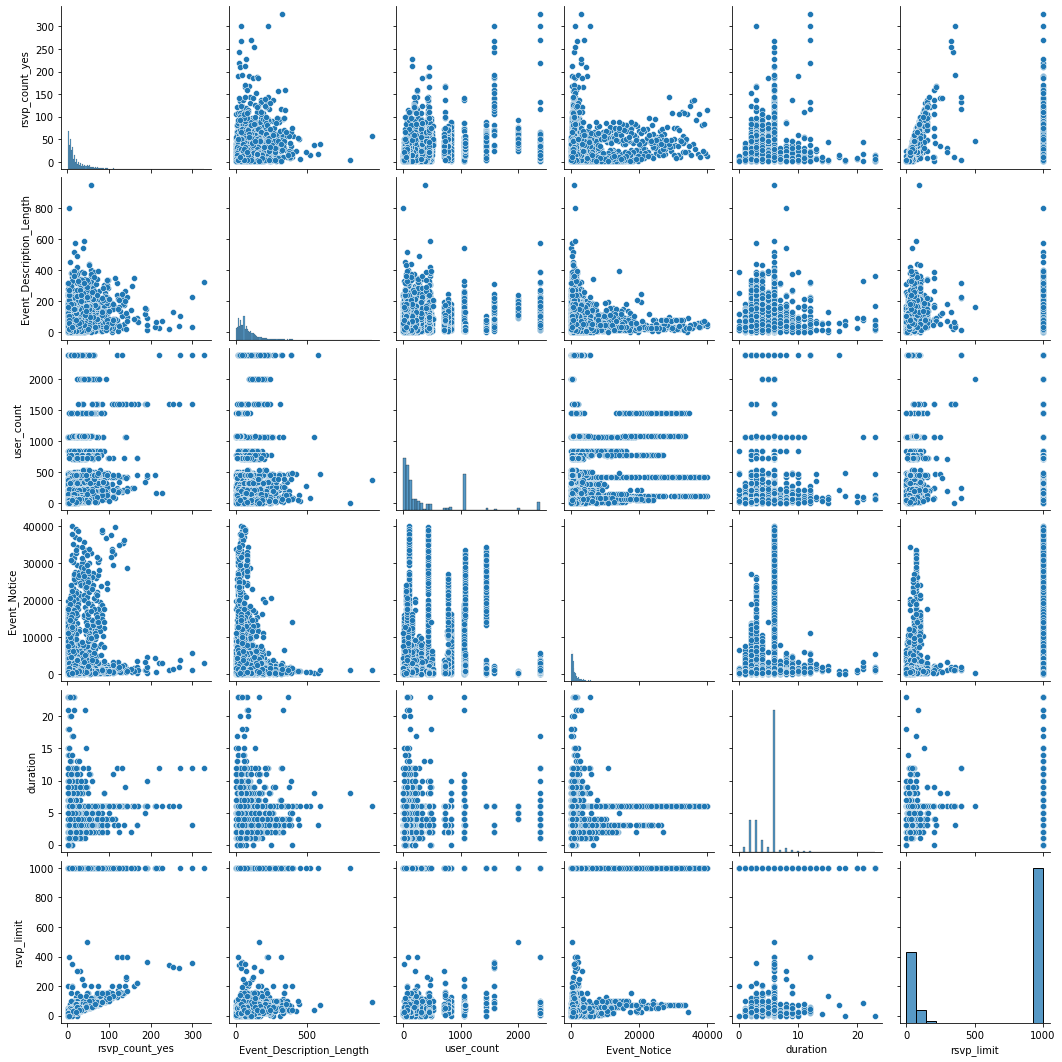

In [226]:
sns.pairplot(filtered_df_API[['rsvp_count_yes', 'Event_Description_Length', 'user_count','Event_Notice','duration','rsvp_limit']])
plt.show();

**Feature Engineering**

In [60]:

filtered_df_API["rsvp_count_yes"] = np.log1p(filtered_df_API["rsvp_count_yes"])

#log transform skewed numeric features:
numeric_feats = filtered_df_API.dtypes[filtered_df_API.dtypes != "object"].index

skewed_feats = filtered_df_API[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

filtered_df_API[skewed_feats] = np.log1p(filtered_df_API[skewed_feats])
filtered_df_API = pd.get_dummies(filtered_df_API)

X, y = filtered_df_API.drop(['rsvp_count_yes'], axis = 1), filtered_df_API['rsvp_count_yes']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [197]:
skewed_feats

Index(['Event_Notice', 'Event_Description_Length', 'duration', 'user_count'], dtype='object')

In [217]:
columns_list=list(X_train.columns.values)

f = open("Column_List.pkl","wb")
pickle.dump(columns_list,f)
f.close()

## Model Selection

In [73]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    model.fit(X, y)
    return(rmse)

In [62]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [63]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [64]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [65]:
RF = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [66]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [67]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [68]:
model_xgb2 = xgb.XGBRegressor(n_estimators=300, learning_rate=0.15,
                              max_depth=8,gamma=0.0,
                              colsample_bytreev= 0.3
                              ,min_child_weight=1,verbosity = 0)

In [445]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6276 (0.0156)



In [71]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.9554 (0.1604)



In [446]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.6257 (0.0155)



In [447]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.6014 (0.0181)



In [448]:
score = rmsle_cv(RF)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 0.5392 (0.0155)



In [449]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.5913 (0.0178)



In [451]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.5361 (0.0137)



In [72]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.7784 (0.0717)



In [74]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[0.80783401 0.86556135 0.75937391 0.80738338 0.65170095]
Xgboost score: 0.7784 (0.0717)



In [202]:
score = rmsle_cv(model_xgb2)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.5092 (0.0209)



Best model is XGBoost

### Hyperparameter Selection

In [75]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

[10:05:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.7049818924537302
Test r2 score:  0.7110643087698338
Train RMSE: 0.4411
Test RMSE: 0.5395


In [76]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.15,max_depth=8,gamma=0.0,colsample_bytreev= 0.3,min_child_weight=1)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

[10:19:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.888003251697953
Test r2 score:  0.7305253417035311
Train RMSE: 0.2958
Test RMSE: 0.5211


In [85]:
def RMSE(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print ('RMSE: %2.3f' % rmse)
    return rmse

In [86]:
xgb_model = XGBRegressor(random_state=0,objective='reg:squarederror',verbosity = 0)

gs_xgb = GridSearchCV(xgb_model, scoring= make_scorer(RMSE, greater_is_better=False) 
                      , param_grid = {'n_estimators': [100,300,1000],
                                      'max_depth': [ 5, 10, 20],
                                      'gamma':[0.0, 0.5],
                                      'learning_rate':[0.05, 0.1, 0.2]}, cv=3)
gs_xgb.fit(X_train, y_train)

RMSE: 0.573
RMSE: 0.581
RMSE: 0.577
RMSE: 0.535
RMSE: 0.551
RMSE: 0.546
RMSE: 0.511
RMSE: 0.530
RMSE: 0.521
RMSE: 0.535
RMSE: 0.543
RMSE: 0.531
RMSE: 0.526
RMSE: 0.530
RMSE: 0.518
RMSE: 0.522
RMSE: 0.522
RMSE: 0.511
RMSE: 0.529
RMSE: 0.541
RMSE: 0.531
RMSE: 0.529
RMSE: 0.538
RMSE: 0.531
RMSE: 0.531
RMSE: 0.536
RMSE: 0.530
RMSE: 0.548
RMSE: 0.560
RMSE: 0.555
RMSE: 0.519
RMSE: 0.538
RMSE: 0.528
RMSE: 0.510
RMSE: 0.525
RMSE: 0.515
RMSE: 0.526
RMSE: 0.535
RMSE: 0.527
RMSE: 0.521
RMSE: 0.525
RMSE: 0.517
RMSE: 0.523
RMSE: 0.521
RMSE: 0.515
RMSE: 0.538
RMSE: 0.543
RMSE: 0.540
RMSE: 0.539
RMSE: 0.540
RMSE: 0.537
RMSE: 0.542
RMSE: 0.540
RMSE: 0.539
RMSE: 0.526
RMSE: 0.547
RMSE: 0.543
RMSE: 0.513
RMSE: 0.526
RMSE: 0.522
RMSE: 0.516
RMSE: 0.524
RMSE: 0.524
RMSE: 0.528
RMSE: 0.532
RMSE: 0.524
RMSE: 0.526
RMSE: 0.525
RMSE: 0.518
RMSE: 0.535
RMSE: 0.528
RMSE: 0.523
RMSE: 0.548
RMSE: 0.542
RMSE: 0.537
RMSE: 0.550
RMSE: 0.541
RMSE: 0.539
RMSE: 0.552
RMSE: 0.541
RMSE: 0.541
RMSE: 0.572
RMSE: 0.580
RMSE

GridSearchCV(cv=3,
             estimator=XGBRegressor(objective='reg:squarederror', verbosity=0),
             param_grid={'gamma': [0.0, 0.5], 'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [100, 300, 1000]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [89]:
best_pars = gs_xgb.best_params_

In [90]:
best_pars

{'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}

In [93]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1,max_depth=5,gamma=0.0)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

[02:12:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.8114083070405327
Test r2 score:  0.7274872020094199
Train RMSE: 0.3702
Test RMSE: 0.5240


In [203]:
# save the model to disk
filename = 'finalized_model_rsvp_pred.sav'
joblib.dump(model_xgb2, filename)

['finalized_model_rsvp_pred.sav']

### Feature Importance

In [204]:
OrderedDict(sorted(model_xgb2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('Event_Notice', 1844),
             ('Event_Description_Length', 778),
             ('rsvp_limit', 480),
             ('user_count', 262),
             ('duration', 178),
             ('Dominant_Topic_3.0', 76),
             ('Dominant_Topic_2.0', 62),
             ('Event_Day_2', 58),
             ('Dominant_Topic_Event_Name_0.0', 57),
             ('Event_Day_1', 51),
             ('Event_Day_3', 47),
             ('Event_Day_4', 40),
             ('Dominant_Topic_0.0', 40),
             ('Dominant_Topic_1.0', 37),
             ('Event_Hour_18', 34),
             ('Event_Hour_17', 32),
             ('Event_Hour_19', 29),
             ('Event_Day_6', 26),
             ('group_id_phpbenelux', 26),
             ('group_id_StartupAmsterdam', 24),
             ('venue_id_68592', 24),
             ('group_id_MICvlaanderen', 23),
             ('Dominant_Topic_Event_Name_1.0', 21),
             ('group_id_Dutch-DIY-Bio', 21),
             ('Event_Day_5', 19),
             ('Dom

## Find Confidence Intervals For XGBoost Model

In [205]:
# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        return grad, hess
    return _log_cosh_quantile

In [206]:
alpha=0.95

In [207]:
# over predict
model_over = XGBRegressor(objective=log_cosh_quantile(alpha),
                              n_estimators=300, learning_rate=0.15,
                              max_depth=8,gamma=0.0,
                              colsample_bytreev= 0.3
                              ,min_child_weight=1,verbosity = 0)

model_over.fit(X_train, y_train)
y_upper_smooth = model_over.predict(X_test)

In [212]:
dill.dump(model_over, open("finalized_model_rsvp_pred_over.pkl", mode='wb')) 

In [208]:
y_upper_smooth

array([2.86051  , 3.13086  , 2.2564862, ..., 3.2850788, 4.0116177,
       3.04769  ], dtype=float32)

In [209]:
# under predict
model_under = XGBRegressor(objective=log_cosh_quantile(1-alpha),
                              n_estimators=300, learning_rate=0.15,
                              max_depth=8,gamma=0.0,
                              colsample_bytreev= 0.3
                              ,min_child_weight=1,verbosity = 0)

model_under.fit(X_train, y_train)
y_lower_smooth = model_under.predict(X_test)

In [211]:
dill.dump(model_under, open("finalized_model_rsvp_pred_under.pkl", mode='wb')) 

In [210]:
y_lower_smooth

array([1.5926603, 2.8043873, 1.6659918, ..., 2.0607195, 2.897849 ,
       1.8787894], dtype=float32)